In [1]:
pip install setfit

  Using cached pyarrow-17.0.0-cp310-cp310-win_amd64.whl.metadata (3.4 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached torch-2.4.1-cp310-cp310-win_amd64.whl.metadata (27 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/75.2 kB ? eta -:--:--
   -------------------------------- ------- 61.4/75.2 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 75.2/75.2 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/471.6 kB ? eta -:--:--
   ------------ --------------------------- 143.4/471.6 kB 4.3 MB/s eta 0:00:01
   ---------------------------------- ----- 409.6/471.6 kB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 471.6/471.6 kB 4.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/84.0 kB ? et

In [2]:
pip install torch --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
from datasets import Dataset
from setfit import SetFitModel, Trainer, TrainingArguments
import torch

# Load your own dataset from CSV file with specific encoding
df = pd.read_csv(r"C:\Users\15011\Documents\Projects\SetFit\Dataset.csv", encoding='ISO-8859-1')

# Convert the DataFrame into a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Split dataset into train and validation sets (80-20 split as an example)
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"]

# Define label mappings for the custom labels
label_mapping = {
    "NEGATIVE": 0,
    "POSITIVE": 1,
    "NEUTRAL": 2,
    "MIXED": 3
}

# Map labels from text to integer indices
train_dataset = train_dataset.map(lambda x: {"label": label_mapping[x["label"]]})
val_dataset = val_dataset.map(lambda x: {"label": label_mapping[x["label"]]})

# Load a SetFit model from Hugging Face Hub, updating the label list
model = SetFitModel.from_pretrained(
    "BAAI/bge-base-en-v1.5",
    labels=["NEGATIVE", "POSITIVE", "NEUTRAL", "MIXED"]
)

# Train the model
args = TrainingArguments(
    batch_size=16,
    max_steps=100,
    logging_steps=10,
    eval_strategy="steps", eval_steps=10, eval_max_steps=100,
    save_strategy="steps", save_steps=50,
    metric_for_best_model="eval_embedding_loss"
)

# Trainer class with correct column mapping
trainer = Trainer(
    model=model, 
    args=args,
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    metric="accuracy",
    column_mapping={"sentence": "text", "label": "label"}  # Mapping sentence to text
)

# Train and evaluate the model
trainer.train()
metrics = trainer.evaluate(val_dataset)
print("Evaluation Metrics:", metrics)

# Save the trained model locally
model_save_path = "./saved_setfit_model"
model.save_pretrained(model_save_path)

# Load the saved model for further use
loaded_model = SetFitModel.from_pretrained(model_save_path)

# Predict with the loaded model
sample_sentences = [
    "This was a pretty good movie!", 
    "Hated this new movie 🤮", 
    "The service was neither great nor terrible.",
    "Loving it and kinda hate myself I didn't buy this day",
    "Should make more content, mane, more light, more content",
    "It is sold out and quite old",
    "I'm really excited to buy this, it's such a sick design",
    "This line is really cool and it's a substitute from GI Joe",
    "I'm really excited"
]

# Predictions from loaded model
preds = loaded_model.predict(sample_sentences)
print("Predictions:", preds)

Map: 100%|██████████| 1095/1095 [00:00<00:00, 13720.10 examples/s]
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Map: 100%|██████████| 4376/4376 [00:00<00:00, 26205.45 examples/s]
***** Running training *****
  Num unique pairs = 1600
  Batch size = 16
  Num epochs = 1
  1%|          | 1/100 [00:42<1:10:20, 42.63s/it]

{'embedding_loss': 0.2515, 'grad_norm': 1.2545405626296997, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}


 10%|█         | 10/100 [02:33<16:38, 11.09s/it] 

{'embedding_loss': 0.2371, 'grad_norm': 0.9252402782440186, 'learning_rate': 2e-05, 'epoch': 0.1}


                                                
 10%|█         | 10/100 [06:42<16:38, 11.09s/it] 

{'eval_embedding_loss': 0.2259172648191452, 'eval_embedding_runtime': 248.8732, 'eval_embedding_samples_per_second': 6.429, 'eval_embedding_steps_per_second': 0.402, 'epoch': 0.1}


 20%|██        | 20/100 [11:28<22:51, 17.14s/it]   

{'embedding_loss': 0.2355, 'grad_norm': 0.9418203234672546, 'learning_rate': 1.7777777777777777e-05, 'epoch': 0.2}


                                                
 20%|██        | 20/100 [15:50<22:51, 17.14s/it] 

{'eval_embedding_loss': 0.2125936895608902, 'eval_embedding_runtime': 261.2589, 'eval_embedding_samples_per_second': 6.124, 'eval_embedding_steps_per_second': 0.383, 'epoch': 0.2}


 30%|███       | 30/100 [18:48<24:14, 20.78s/it]  

{'embedding_loss': 0.2074, 'grad_norm': 1.1995055675506592, 'learning_rate': 1.555555555555556e-05, 'epoch': 0.3}


                                                
 30%|███       | 30/100 [23:09<24:14, 20.78s/it] 

{'eval_embedding_loss': 0.19773219525814056, 'eval_embedding_runtime': 261.4611, 'eval_embedding_samples_per_second': 6.119, 'eval_embedding_steps_per_second': 0.382, 'epoch': 0.3}


 40%|████      | 40/100 [26:09<19:47, 19.80s/it]  

{'embedding_loss': 0.1812, 'grad_norm': 0.881482720375061, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.4}


                                                
 40%|████      | 40/100 [30:34<19:47, 19.80s/it] 

{'eval_embedding_loss': 0.17767152190208435, 'eval_embedding_runtime': 265.4205, 'eval_embedding_samples_per_second': 6.028, 'eval_embedding_steps_per_second': 0.377, 'epoch': 0.4}


 50%|█████     | 50/100 [31:52<08:44, 10.50s/it]  

{'embedding_loss': 0.1783, 'grad_norm': 1.2074666023254395, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}


                                                
 50%|█████     | 50/100 [37:08<08:44, 10.50s/it] 

{'eval_embedding_loss': 0.15698091685771942, 'eval_embedding_runtime': 316.088, 'eval_embedding_samples_per_second': 5.062, 'eval_embedding_steps_per_second': 0.316, 'epoch': 0.5}


 60%|██████    | 60/100 [38:39<08:49, 13.23s/it]   

{'embedding_loss': 0.1693, 'grad_norm': 1.4127482175827026, 'learning_rate': 8.888888888888888e-06, 'epoch': 0.6}


                                                
 60%|██████    | 60/100 [43:57<08:49, 13.23s/it] 

{'eval_embedding_loss': 0.14287929236888885, 'eval_embedding_runtime': 318.2682, 'eval_embedding_samples_per_second': 5.027, 'eval_embedding_steps_per_second': 0.314, 'epoch': 0.6}


 70%|███████   | 70/100 [45:43<07:18, 14.61s/it]   

{'embedding_loss': 0.1501, 'grad_norm': 1.493636965751648, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.7}


                                                
 70%|███████   | 70/100 [50:48<07:18, 14.61s/it] 

{'eval_embedding_loss': 0.1363300383090973, 'eval_embedding_runtime': 304.1493, 'eval_embedding_samples_per_second': 5.261, 'eval_embedding_steps_per_second': 0.329, 'epoch': 0.7}


 80%|████████  | 80/100 [52:34<04:55, 14.77s/it] 

{'embedding_loss': 0.1417, 'grad_norm': 1.6809134483337402, 'learning_rate': 4.444444444444444e-06, 'epoch': 0.8}


                                                
 80%|████████  | 80/100 [57:08<04:55, 14.77s/it] 

{'eval_embedding_loss': 0.1311153620481491, 'eval_embedding_runtime': 274.5751, 'eval_embedding_samples_per_second': 5.827, 'eval_embedding_steps_per_second': 0.364, 'epoch': 0.8}


 90%|█████████ | 90/100 [58:29<01:43, 10.38s/it]

{'embedding_loss': 0.131, 'grad_norm': 1.5209349393844604, 'learning_rate': 2.222222222222222e-06, 'epoch': 0.9}


                                                
 90%|█████████ | 90/100 [1:02:59<01:43, 10.38s/it]

{'eval_embedding_loss': 0.12777085602283478, 'eval_embedding_runtime': 269.9942, 'eval_embedding_samples_per_second': 5.926, 'eval_embedding_steps_per_second': 0.37, 'epoch': 0.9}


100%|██████████| 100/100 [1:04:13<00:00, 11.01s/it]

{'embedding_loss': 0.1411, 'grad_norm': 1.5463285446166992, 'learning_rate': 0.0, 'epoch': 1.0}


                                                   
100%|██████████| 100/100 [1:08:17<00:00, 11.01s/it]

{'eval_embedding_loss': 0.12670928239822388, 'eval_embedding_runtime': 244.1407, 'eval_embedding_samples_per_second': 6.554, 'eval_embedding_steps_per_second': 0.41, 'epoch': 1.0}


100%|██████████| 100/100 [1:08:19<00:00, 40.99s/it]


{'train_runtime': 4099.2649, 'train_samples_per_second': 0.39, 'train_steps_per_second': 0.024, 'train_loss': 0.1774081063270569, 'epoch': 1.0}


Applying column mapping to the evaluation dataset
***** Running evaluation *****


Evaluation Metrics: {'accuracy': 0.8730593607305936}
Predictions: ['POSITIVE', 'NEGATIVE', 'NEGATIVE', 'MIXED', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE']


Confusion Matrix:
 [[ 60  32   2  15]
 [ 10 363  11   4]
 [  2  25  42  17]
 [  6  11   4 491]]


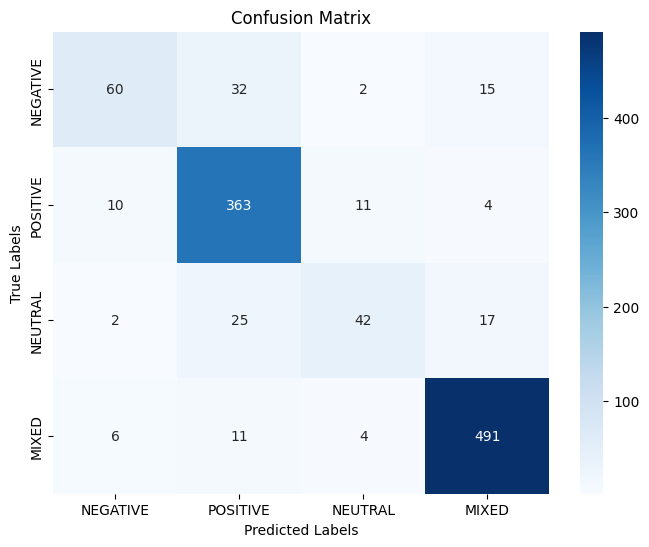

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.77      0.55      0.64       109
    POSITIVE       0.84      0.94      0.89       388
     NEUTRAL       0.71      0.49      0.58        86
       MIXED       0.93      0.96      0.95       512

    accuracy                           0.87      1095
   macro avg       0.81      0.73      0.76      1095
weighted avg       0.87      0.87      0.87      1095



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 12: Load the saved model for further use
loaded_model = SetFitModel.from_pretrained(model_save_path)

# Step 13: Predict on the validation set
val_sentences = val_dataset["sentence"]
true_labels = val_dataset["label"]

# Convert true labels from integers to their original labels for evaluation
true_labels_str = [list(label_mapping.keys())[list(label_mapping.values()).index(label)] for label in true_labels]

# Predictions on the validation set
predicted_labels = loaded_model.predict(val_sentences)

# Step 14: Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_str, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix using seaborn
labels = ["NEGATIVE", "POSITIVE", "NEUTRAL", "MIXED"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 15: Generate classification report for detailed metrics (precision, recall, f1-score)
classification_rep = classification_report(true_labels_str, predicted_labels, target_names=labels)
print("Classification Report:\n", classification_rep)


In [ ]:
!pip install setfit
!pip install torch --index-url https://download.pytorch.org/whl/cu118
!pip install datasets

import pandas as pd
from datasets import Dataset
from setfit import SetFitModel, Trainer, TrainingArguments
import torch
from google.colab import files
import shutil

# Step 1: Load your dataset from Colab directory
df = pd.read_csv("/content/Dataset.csv", encoding='ISO-8859-1')

# Step 2: Convert the DataFrame into a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Step 3: Split dataset into train and validation sets (80-20 split as an example)
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"]

# Step 4: Define label mappings for the custom labels
label_mapping = {
    "NEGATIVE": 0,
    "POSITIVE": 1,
    "NEUTRAL": 2,
    "MIXED": 3
}

# Step 5: Map labels from text to integer indices
train_dataset = train_dataset.map(lambda x: {"label": label_mapping[x["label"]]})
val_dataset = val_dataset.map(lambda x: {"label": label_mapping[x["label"]]})

# Step 6: Load a SetFit model from Hugging Face Hub, updating the label list
model = SetFitModel.from_pretrained(
    "BAAI/bge-base-en-v1.5",
    # "BAAI/bge-large-en-v1.5",
    labels=["NEGATIVE", "POSITIVE", "NEUTRAL", "MIXED"]
)


# Step 7: Train the model
args = TrainingArguments(
    output_dir = 'checkpoints',               # output saved in checkpoints
    batch_size=(16, 2),                       # (16->body,1->head)
    max_steps=800,                            # max number of training steps(overrides the num_epochs)
    num_epochs=3,                             # the model will train on entire dataset 3 times
    logging_steps=10,                         # for storing the lo files
    sampling_strategy="oversampling",         # for gettin the sentancepair(similar sentances pair)
    # oversampling (draws an even number of positive and negative sentence pairs during training)- used when dataset is imbalanced,
    # undersampling  (draws the minimum number of positive/negative pairs so that the minority class determines how many pairs are drawn)- majority class is very dominant
    # unique (draws every possible pair combination of sentences, without balancing between positive and negative pairs) -have a small dataset or relatively balanced classes
    num_iterations=5,
    end_to_end="True",                         # True -> training both head(decoder) and body(encoder)
    body_learning_rate=(2e-5, 1e-5),          # learning ratev for the encoder
    head_learning_rate=4e-2,                  #1e-2 -> reduced it for more training of head(decoder)
    eval_strategy="steps",
    eval_steps=20,                            # first step at which evalution will occur
    eval_delay= 20,                            # after no of steps the avalution will occur
    eval_max_steps=140,
    save_strategy="steps",
    save_steps=100,                           # Number of updates steps before two checkpoint(should be multiple of "eval_steps")
    metric_for_best_model="eval_embedding_loss",
    load_best_model_at_end="True"                 # load the best model at end if true
)
# ( 
# output_dir: str = 'checkpoints'
# batch_size: Union[int, Tuple[int, int]] = (16, 2)
# num_epochs: Union[int, Tuple[int, int]] = (1, 16)
# max_steps: int = -1
# sampling_strategy: str = 'oversampling'    # 
# num_iterations: Optional[int] = None
# body_learning_rate: Union[float, Tuple[float, float]] = (2e-05, 1e-05)
# head_learning_rate: float = 0.01
# loss: Callable = <class 'sentence_transformers.losses.CosineSimilarityLoss.CosineSimilarityLoss'>
# distance_metric: Callable = <function BatchHardTripletLossDistanceFunction.cosine_distance at 0x7f677476df30>
# margin: float = 0.25
# end_to_end: bool = False
# use_amp: bool = False
# warmup_proportion: float = 0.1
# l2_weight: Optional[float] = 0.01
# max_length: Optional[int] = None
# samples_per_label: int = 2
# show_progress_bar: bool = Trueseed: int = 42
# report_to: str = 'all'
# run_name: Optional[str] = None
# logging_dir: Optional[str] = None
# logging_strategy: str = 'steps'
# logging_first_step: bool = True
# logging_steps: int = 50
# eval_strategy: str = 'no'
# evaluation_strategy: Optional[str] = None
# eval_steps: Optional[int] = None
# eval_delay: int = 0
# eval_max_steps: int = -1
# save_strategy: str = 'steps'
# save_steps: int = 500
# save_total_limit: Optional[int] = 1
# load_best_model_at_end: bool = False
# metric_for_best_model: Optional[str] = 'embedding_loss'
# greater_is_better: bool = False 
# )

# Step 8: Trainer class with correct column mapping
trainer = Trainer(
    model=model, 
    args=args,
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    metric="accuracy",
    column_mapping={"sentence": "text", "label": "label"}  # Mapping sentence to text
)

# Step 9: Train and evaluate the model
trainer.train()
metrics = trainer.evaluate(val_dataset)
print("Evaluation Metrics:", metrics)

# Step 10: Save the trained model locally within Colab
model_save_path = "/content/saved_setfit_model"
model.save_pretrained(model_save_path)

# Step 11: Download the trained model to your local machine
# Compress the saved model directory for download
shutil.make_archive("/content/saved_setfit_model", 'zip', model_save_path)

# Download the zip file
files.download("/content/saved_setfit_model.zip")



# Step 12: Load the saved model for further use
loaded_model = SetFitModel.from_pretrained(model_save_path)

# Step 13: Predict with the loaded model
sample_sentences = [
    
"More locations would be helpful...it is challenging to get to the [Doctor]ronto location... ",
"I deeply appreciate the care that I am receiving at [Clinic]. For the first time in my life I am receiving high quality Diagnostic and Preventative Medical Care and its dramatically improved both my physical",
"Disappointed in the dermatology/cosmetology consult.  Instead of providing useful feedback it was just a full session of being upsold on procedures that I didnt ask for.  Also the hearing/vision tests ",
"A little more heads up on that schedule and who you will be seeing. ",
"Excellent compassionate personal staff",
"Appointments were very unorganized at the end of the day and it would have been helpful to been provided with a schedule so it was clear what came next. I was also told the doctor would email me after "
]
# NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE

# Predictions from loaded model
preds = loaded_model.predict(sample_sentences)
print("Predictions:", preds)


# running on entire data

# Step 12: Load the saved model for further use
loaded_model = SetFitModel.from_pretrained(model_save_path)

# Step 13: Predict with the loaded model for the entire dataset
# Add a 'Predicted Label' column based on model predictions
dataset_df = df.copy()  # Keep the original dataframe intact

# Run predictions on the text column (assuming the column containing text is 'sentence')
pred_labels = loaded_model.predict(dataset_df['sentence'].tolist())  # Predictions are already in label format (strings)

# Step 14: Add predictions as a new column in the original DataFrame
dataset_df['Predicted Label'] = pred_labels
dataset_df = dataset_df[dataset_df['label'].notna() & (dataset_df['label'] != "")]
# Step 15: Save the DataFrame with predictions to a new CSV file
output_csv_path = "/content/predicted_results.csv"
dataset_df.to_csv(output_csv_path, index=False)

# Step 16: Download the resulting CSV file
files.download(output_csv_path)


# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 12: Load the saved model for further use
loaded_model = SetFitModel.from_pretrained(model_save_path)

# Step 13: Predict on the validation set
val_sentences = val_dataset["sentence"]
true_labels = val_dataset["label"]

# Convert true labels from integers to their original labels for evaluation
true_labels_str = [list(label_mapping.keys())[list(label_mapping.values()).index(label)] for label in true_labels]

# Predictions on the validation set
predicted_labels = loaded_model.predict(val_sentences)

# Step 14: Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_str, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix using seaborn
labels = ["NEGATIVE", "POSITIVE", "NEUTRAL", "MIXED"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 15: Generate classification report for detailed metrics (precision, recall, f1-score)
classification_rep = classification_report(true_labels_str, predicted_labels, target_names=labels)
print("Classification Report:\n", classification_rep)
